In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
# load dataset
df = pd.read_csv("./dataset/Results_21Mar2022.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mc_run_id       72000 non-null  int64  
 1   grouping        72000 non-null  object 
 2   mean_ghgs       72000 non-null  float64
 3   mean_land       72000 non-null  float64
 4   mean_watscar    72000 non-null  float64
 5   mean_eut        72000 non-null  float64
 6   mean_ghgs_ch4   72000 non-null  float64
 7   mean_ghgs_n2o   72000 non-null  float64
 8   mean_bio        72000 non-null  float64
 9   mean_watuse     72000 non-null  float64
 10  mean_acid       72000 non-null  float64
 11  sd_ghgs         72000 non-null  float64
 12  sd_land         72000 non-null  float64
 13  sd_watscar      72000 non-null  float64
 14  sd_eut          72000 non-null  float64
 15  sd_ghgs_ch4     72000 non-null  float64
 16  sd_ghgs_n2o     72000 non-null  float64
 17  sd_bio          72000 non-null 

In [3]:
# unique values
print("diet_group: {}".format(df["diet_group"].unique()))
print("age_group: {}".format(df["age_group"].unique()))
print("sex: {}".format(df["sex"].unique()))


diet_group: ['fish' 'meat50' 'meat100' 'meat' 'vegan' 'veggie']
age_group: ['20-29' '30-39' '40-49' '50-59' '60-69' '70-79']
sex: ['female' 'male']


In [4]:
# convert diet_group labels
df['diet_group'] = df['diet_group'].map({
    "meat100": "High meat-eaters (>=100g/d)",
    "meat50": "Medium meat-eaters (50-99g/d)",
    "meat": "Low meat-eaters (<50g/d)",
    "fish": "Fish-eaters",
    "veggie": "Vegetarians",
    "vegan": "Vegans"
})
# convert sex labels
df["sex"] = df["sex"].map({
    "male": "Male",
    "female": "Female"
})


In [5]:
# select environmental impacts feature columns
env_columns = [
    "mean_ghgs", "mean_land", "mean_watscar", "mean_eut",
    "mean_ghgs_ch4", "mean_ghgs_n2o", "mean_bio",
    "mean_watuse", "mean_acid"
]

df[env_columns].describe().T


,count,mean,std,min,25%,50%,75%,max
mean_ghgs,72000.0,6.173568,3.090398,1.878054,4.272191,5.460742,7.498673,20.543958
mean_land,72000.0,10.610860,8.774950,3.085156,5.833910,7.634004,11.766317,74.490099
mean_watscar,72000.0,18324.502556,5761.426137,5581.200606,14473.366153,17340.934265,20962.489797,57642.741520
mean_eut,72000.0,24.619412,10.440526,7.403603,17.490146,22.741543,30.143916,85.043624
mean_ghgs_ch4,72000.0,1.137918,0.773895,0.065370,0.664186,0.978820,1.492675,5.376923
mean_ghgs_n2o,72000.0,0.437283,0.225046,0.123047,0.279034,0.371027,0.529600,1.508414
mean_bio,72000.0,274.693823,158.917024,54.748545,163.291618,232.676491,345.247131,1426.913345
mean_watuse,72000.0,739.712660,318.236794,192.729916,541.813501,692.166596,859.515193,3333.230647
mean_acid,72000.0,27.552727,11.631872,7.466161,21.159961,25.561232,33.688857,76.266195


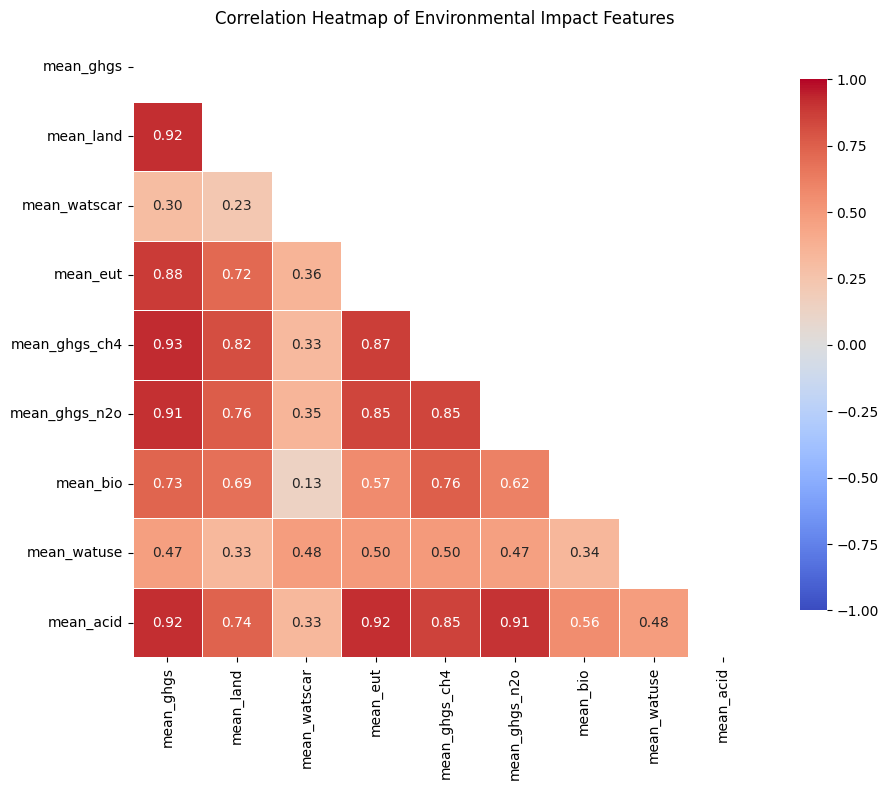

In [6]:
# calculate correlation matrix
corr_matrix = df[env_columns].corr(method='pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# correlation matrix (heatmap)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.85}
)
plt.title("Correlation Heatmap of Environmental Impact Features")
plt.tight_layout()
plt.show()


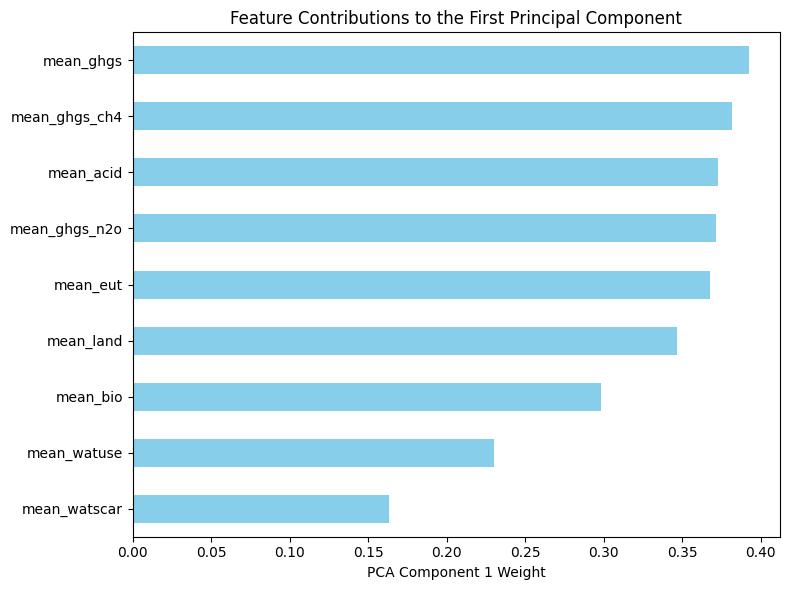

In [ ]:
# use PCA to show the importance of environmental impact features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df[env_columns])
pca = PCA()
pca.fit(X_scaled)

# visualize weights
weights = pd.Series(pca.components_[0], index=env_columns).sort_values(key=abs, ascending=False)
weights.plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.title("Feature Contributions to the First Principal Component")
plt.xlabel("PCA Component 1 Weight")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Use `mean_ghgs` to visualize treemap

In [43]:
# aggregate by diet_group -> age_group -> sex and calculate means
agg_df = df.groupby(["diet_group", "age_group", "sex"]).agg({
    "mean_ghgs": "mean",
    "n_participants": "mean"  # area of treemap
}).reset_index()

# create root node of treemap
agg_df["All"] = "All Groups"
# create treemap
fig = px.treemap(
    agg_df,
    path=[px.Constant("All"), "diet_group", "age_group", "sex"],
    values="n_participants",  # area: size of population
    color="mean_ghgs",  # color: greenhouse gas emissions per capita
    color_continuous_scale="RdYlGn_r",
    color_continuous_midpoint=agg_df["mean_ghgs"].mean(),
    hover_data={"mean_ghgs": True, "n_participants": True}
)

# custom hover-over and text and values
fig.update_traces(hovertemplate="<b>%{parent}</b><br>Age Group: %{label}<br>Size of Population: %{value}<br>Mean GHGs: %{customdata[0]:.2f}<extra></extra>")

# custom treemap title and colorbar
fig.update_layout(
    title="Treemap of Greenhouse Gas Emissions by Diet, Age Group, and Sex",
    coloraxis_colorbar=dict(title="Mean GHG (kg/d)",
                            title_font=dict(size=15),
                            thickness=50),
    margin=dict(t=50, l=25, r=25, b=25)
)
fig.show()
fig.write_html("./treemap_mean_ghgs.html")  # save treemap as html file
